In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from gekko import GEKKO

In [3]:
plt.rcParams['figure.figsize'] = (15, 3)
sns.set_style('whitegrid')

In [4]:
def create_df(house):
    
    df = pd.read_csv("C:/Users/vidis/OneDrive/Desktop/Spring23/BachelorProject/complete_dataset.csv")
    ef = pd.read_csv("C:/Users/vidis/OneDrive/Desktop/Spring23/BachelorProject/Elspotprices.csv",sep=';',decimal=',')
    cf = pd.read_csv("carbon_emissions_data.csv",decimal=',')
    
    df['Time'] = pd.to_datetime(df['Time'])
    ef['HourDK'] = pd.to_datetime(ef['HourDK'])
    cf['Minutes5DK'] = pd.to_datetime(cf['Minutes5DK'])
    
    mf = ef[ef['PriceArea']=='DK1'].merge(df,left_on='HourDK', right_on='Time')
    mf = mf.merge(cf, left_on = 'HourDK', right_on = 'Minutes5DK')
    
    data = pd.DataFrame()
    data['prod'] = mf[f'prod_{str(house)}'].to_numpy()
    data['cons'] = mf[f'cons_{str(house)}'].to_numpy()
    data['yield'] = (data['prod']-data['cons']).to_numpy()
    data['price'] = mf['SpotPriceDKK'].to_numpy()/1000
    data['carbon'] = mf['CO2Emission'].to_numpy()
    data['time'] = mf['Time'].to_numpy()
    return data

In [166]:
def MPCopt(start_time='2020-12-22 01:00:00', end_time = '2020-12-23 01:00:00', house='h16', ini_bat_state=0,sbr_val = 0.5, deg_rate=0.05, num_dec=3):
    df = create_df(house)
    
    start_ind = int(df[df['time']==str(start_time)].index[0])
    end_ind = int(df[df['time']==str(end_time)].index[0]) #inclusive or exclusive?
    
    n = end_ind-start_ind
    max_charge = 7.0
    max_cap = 13.0
    
    m = GEKKO()
    charge = m.Array(m.Var, n, lb=-max_charge, ub=max_charge)
    bat_state = m.Array(m.Var, n, lb=0.0, ub=max_cap)
    
    df = create_df(house)
    yieldd = df['yield'][start_ind:start_ind+n].to_numpy()
    price = df['price'][start_ind:start_ind+n].to_numpy()

    # Define constraints
    m.Equation(bat_state[0] == ini_bat_state)
    m.Equation([np.abs(charge[i]) <= max_charge])
    m.Equation([bat_state[i+1] == bat_state[i]*(1-deg_rate)+charge[i] for i in range(n-1)])
    m.Equation([bat_state[i+1] <= max_cap for i in range(n-1)])

    # Define objective
    y = m.Array(m.Var, n)
    s = m.Array(m.Var, n)
    p = m.Array(m.Var, n)

    m.Equations([y[i] == yieldd[i] for i in range(n)])
    m.Equations([s[i] == y[i] - charge[i] for i in range(n)])
    m.Equations([p[i] == price[i] for i in range(n)])

    cumm_cost = sum([m.if3(s[i],-1*s[i]*p[i], -sbr_val*s[i]*p[i]) for i in range(n)])
    m.Obj(cumm_cost)

    # Solver details
    m.options.IMODE = 3
    m.options.SOLVER = 3
    m.solve()
    
    of = pd.DataFrame()
    of['time'] = df['time'][start_ind:start_ind+n].to_numpy()
    of['prod'] = df['prod'][start_ind:start_ind+n].to_numpy()
    of['cons'] = df['cons'][start_ind:start_ind+n].to_numpy()
    of['yield'] = [y[i][0] for i in range(n)]
    of['charge'] = [charge[i][0] for i in range(n)]
    of['state'] = [bat_state[i][0] for i in range(n)]
    of['surplus'] = [s[i][0] for i in range(n)]
    of['price'] = df['price'][start_ind:start_ind+n].to_numpy()
    of['costs'] = [-1*p[i][0]*s[i][0] if s[i][0]<0 else -1*p[i][0]*sbr_val*s[i][0] for i in range(n)]
    of['cumm_costs'] = of['costs'].cumsum()
    
    return of.round(5)

In [187]:
class MPC:
    def __init__(self, start_time='2020-12-22 01:00:00', end_time = '2020-12-23 01:00:00', house='h16', ini_bat_state=0,sbr_val = 0.5, deg_rate=0.05, num_dec=3):
        self.start_time = start_time
        self.end_time = end_time
        self.house = house
        self.ini_bat_state = ini_bat_state
        self.sbr_val = sbr_val
        self.deg_rate = deg_rate
        self.num_dec = num_dec
    
        self.data = create_df(self.house)
        self.opt = MPCopt(self.start_time, self.end_time, self.house, self.ini_bat_state, self.sbr_val, self.deg_rate, self.num_dec)
    
    def return_data(self):
        return self.data
    
    def return_opt(self):
        return self.opt
    
    def full_plot(self, drop=[]):
        temp = self.opt.copy()
        temp = temp.drop(drop, axis=1)
        temp.set_index(pd.to_datetime(temp['time']),inplace=True)
        temp=temp.drop(['time'],axis=1)
        temp.plot()
        plt.title(f'MCP for house {self.house} at {self.start_time}')
        plt.xlabel('Timestep')
        plt.ylabel('')
        plt.show()
    
    def mag_plot(self,drop=[], start=0,end=5):
        temp = self.opt.copy()
        temp = temp.drop(drop, axis=1)
        temp[start:end].plot()
        plt.title(f'MCP for house {self.house}, index {self.start_ind}, magnified: {start}:{end}')
        plt.xlabel('Timestep')
        plt.ylabel('')
        plt.show()
    

In [188]:
M1 = MPC()

apm 176.22.108.129_gk_model47 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :          240
   Intermediates:            0
   Connections  :            0
   Equations    :          193
   Residuals    :          193
 
 Number of state variables:            240
 Number of total equations: -          192
 Number of slack variables: -           72
 ---------------------------------------
 Degrees of freedom       :            -24
 
 * Warning: DOF <= 0
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

************************************************************************

  75  2.2701068e+01 3.12e-09 1.51e+05  -3.2 3.13e-01    -  1.00e+00 5.46e-02f  1
  76  2.2709713e+01 3.16e-10 1.18e+03  -3.4 1.65e-01    -  1.00e+00 1.00e+00f  1
  77  2.2709721e+01 1.58e-09 7.61e-01  -3.4 9.04e-05   3.9 1.00e+00 1.00e+00F  1
  78  2.2709725e+01 6.44e-10 1.17e+04  -3.4 9.69e-05   3.4 1.00e+00 5.00e-01h  2
  79  2.2709743e+01 3.98e-10 1.17e+00  -3.4 1.90e-04   2.9 1.00e+00 1.00e+00F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  2.2709771e+01 6.60e-10 2.14e+00  -3.4 3.36e-04   2.5 1.00e+00 1.00e+00F  1
  81  2.2709781e+01 4.05e-10 1.12e+04  -3.4 5.28e-04   2.0 1.00e+00 2.50e-01f  3
  82  2.2709781e+01 8.35e-11 2.67e-01  -3.4 1.30e-05   4.2 1.00e+00 1.00e+00h  1
  83  2.2709782e+01 2.84e-12 1.06e-01  -3.4 1.89e-05   3.8 1.00e+00 1.00e+00h  1
  84  2.2709769e+01 5.88e-11 6.61e+03  -5.1 1.88e-05   3.3 9.20e-01 1.00e+00f  1
  85  2.2699638e+01 5.38e-11 1.78e+03  -5.1 2.53e+00    -  7.48e-01 8.83e-02f  1
  86  2.2698415e+01 8.65e-09

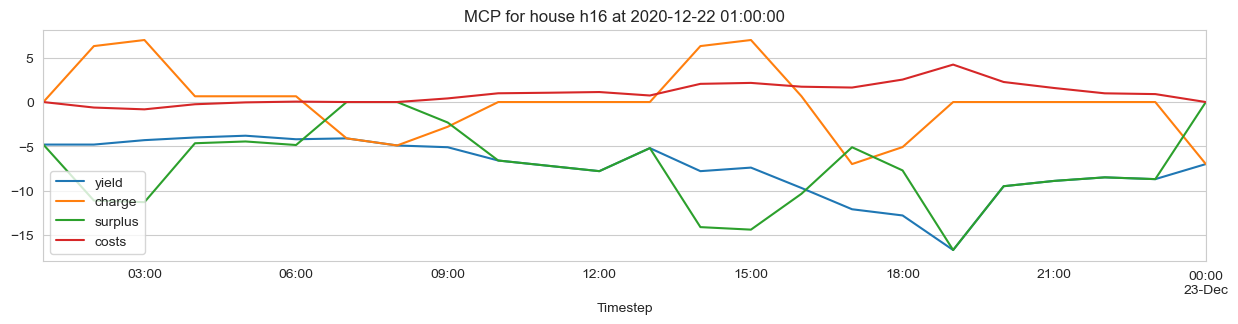

In [191]:
M1.full_plot(drop=['cumm_costs','price','prod','cons','state'])